# Hybrid Model Training Pipeline - CICIDS2017

Complete notebook covering:
1. Data Exploration
2. Preprocessing
3. Model Training (6 hybrid models)
4. Evaluation & Comparison

Models: CNN-SVM, LSTM-RF, CNN-LSTM-MLP, Autoencoder-CNN, Attention-LSTM, Stacking Ensemble

## 1. Setup & Imports

In [1]:
import sys
from pathlib import Path
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.datasets.cicids2017 import CICIDS2017Loader
from src.evaluation.comprehensive_metrics import ComprehensiveEvaluator

print(f"Project root: {project_root}")
print(f"Working directory: {Path.cwd()}")

# Set visualization defaults
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Project root: c:\Users\fadh\Documents\python\kss\cybersecurity-threat-detection
Working directory: c:\Users\fadh\Documents\python\kss\cybersecurity-threat-detection\notebooks


## 2. Data Exploration

In [2]:
# Load and preprocess CICIDS2017 dataset
data_dir = project_root / "data" / "raw" / "CICIDS2017"
print(f"Loading data from: {data_dir}")

loader = CICIDS2017Loader(str(data_dir))

# Full preprocessing pipeline
X_train, X_test, y_train, y_test = loader.preprocess_pipeline(
    test_size=0.2, 
    apply_smote=False  # We'll apply SMOTE separately later
)

print(f"\nDataset loaded and preprocessed!")
print(f"Train set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")

Loading data from: c:\Users\fadh\Documents\python\kss\cybersecurity-threat-detection\data\raw\CICIDS2017

  CICIDS2017 PREPROCESSING PIPELINE

  LOADING CICIDS2017 DATASET

Found 8 CSV files:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv

Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
  Shape: (225745, 79)

Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
  Shape: (225745, 79)

Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
  Shape: (286467, 79)

Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
  Shape: (286467, 79)

Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
  Shape: (191033, 79)

L


Class Distribution (Train Set):
 Class   Count  Percentage
     0 1677760   83.195893
     1  257407   12.764165
     2   72555    3.597820
     3    1558    0.077257
     4      29    0.001438
     5    7320    0.362980
     6       9    0.000446


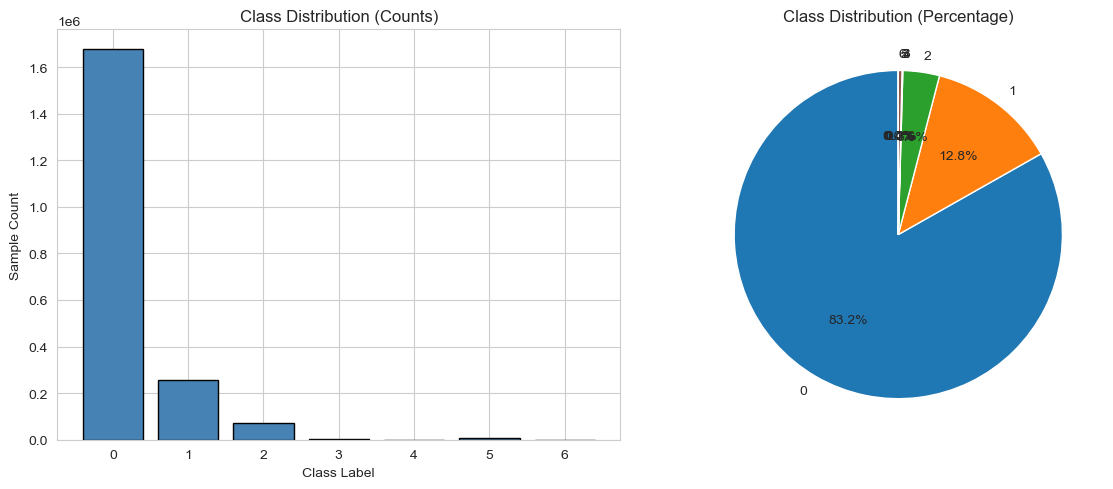


Class Imbalance Ratio: 186417.78:1
Majority class samples: 1,677,760
Minority class samples: 9


In [6]:
# Class distribution in training set
unique, counts = np.unique(y_train, return_counts=True)
class_dist = pd.DataFrame({
    'Class': unique, 
    'Count': counts, 
    'Percentage': counts/len(y_train)*100
})
print("\nClass Distribution (Train Set):")
print(class_dist.to_string(index=False))

# Visualize class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xlabel('Class Label')
plt.ylabel('Sample Count')
plt.title('Class Distribution (Counts)')
plt.xticks(unique)

plt.subplot(1, 2, 2)
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')
plt.tight_layout()
plt.show()

# Check class imbalance ratio
majority_class = counts.max()
minority_class = counts.min()
imbalance_ratio = majority_class / minority_class
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Majority class samples: {majority_class:,}")
print(f"Minority class samples: {minority_class:,}")

## 3. Apply SMOTE Balancing

The data is already preprocessed (scaled and split). Now we'll apply SMOTE to balance the training set.

In [ ]:
# Apply SMOTE for balancing (data already scaled and split)
from imblearn.over_sampling import SMOTE

print(f"Before SMOTE: {X_train.shape[0]:,} samples")

# Reshape X_train from 3D to 2D for SMOTE
X_train_2d = X_train.reshape(X_train.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_2d, y_train)

# Reshape back to original 3D shape (for models that need it)
# X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], X_train.shape[1], X_train.shape[2])

print(f"After SMOTE: {X_train_balanced.shape[0]:,} samples")

# Check balanced distribution
unique_bal, counts_bal = np.unique(y_train_balanced, return_counts=True)
bal_dist = pd.DataFrame({'Class': unique_bal, 'Count': counts_bal})
print("\nBalanced Class Distribution:")
print(bal_dist.to_string(index=False))

# Save preprocessed data to results/data/ so training script can load it
results_data_dir = project_root / "results" / "data"
results_data_dir.mkdir(parents=True, exist_ok=True)

np.save(results_data_dir / "X_train.npy", X_train_balanced)
np.save(results_data_dir / "X_test.npy", X_test)
np.save(results_data_dir / "y_train.npy", y_train_balanced)
np.save(results_data_dir / "y_test.npy", y_test)

print(f"\n✅ Preprocessed data saved to: {results_data_dir}")
print(f"   Training script can now use --load-preprocessed flag to skip preprocessing")

Before SMOTE: 2,016,638 samples


## 4. Model Training Configuration

In [4]:
# Training configuration
config = {
    'dataset': 'cicids2017',  
    'data_path': 'data/raw/CICIDS2017',
    'models': 'cnn_svm,lstm_rf,cnn_lstm_mlp,autoencoder_cnn,attention_lstm,stacking',
    'epochs': 10,
    'batch_size': 1024,
    'sample_ratio': 0.05,  # None = use full dataset; 0.1 = 10%, etc
    'apply_smote': False,  # Already applied in notebook above!
    'load_preprocessed': True,  # Load from results/data/ (preprocessed in notebook)
    'resume': True,  # Set to True to skip already trained models
    'fit_verbose': 2,  # 0=silent, 1=progress bar, 2=per-epoch
    'output_dir': 'results',
    'shutdown': False,
    'shutdown_delay': 60,
}

print("Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Build command
script_path = project_root / "scripts" / "train_all_models.py"
cmd = [
    sys.executable,
    str(script_path),
    '--dataset', config['dataset'],
    '--data-path', config['data_path'],
    '--models', config['models'],
    '--epochs', str(config['epochs']),
    '--batch-size', str(config['batch_size']),
    '--fit-verbose', str(config['fit_verbose']),
    '--output-dir', config['output_dir'],
]

if config['sample_ratio'] is not None:
    cmd.extend(['--sample-ratio', str(config['sample_ratio'])])
if config['apply_smote']:
    cmd.append('--apply-smote')
if config['load_preprocessed']:
    cmd.append('--load-preprocessed')
if config['resume']:
    cmd.append('--resume')
if config['shutdown']:
    cmd.extend(['--shutdown', '--shutdown-delay', str(config['shutdown_delay'])])

print(f"\nCommand to execute:")
print(" ".join(cmd))

Training Configuration:
  dataset: cicids2017
  data_path: data/raw/CICIDS2017
  models: cnn_svm,lstm_rf,cnn_lstm_mlp,autoencoder_cnn,attention_lstm,stacking
  epochs: 10
  batch_size: 1024
  sample_ratio: 0.05
  apply_smote: False
  load_preprocessed: True
  resume: True
  fit_verbose: 2
  output_dir: results
  shutdown: False
  shutdown_delay: 60

Command to execute:
c:\ProgramData\anaconda3\python.exe c:\Users\fadh\Documents\python\kss\cybersecurity-threat-detection\scripts\train_all_models.py --dataset cicids2017 --data-path data/raw/CICIDS2017 --models cnn_svm,lstm_rf,cnn_lstm_mlp,autoencoder_cnn,attention_lstm,stacking --epochs 10 --batch-size 1024 --fit-verbose 2 --output-dir results --sample-ratio 0.05 --load-preprocessed --resume


## 5. Execute Training

Run the training script with the configured parameters. This will train all 6 hybrid models:
- CNN-SVM
- LSTM-RF  
- CNN-LSTM-MLP
- Autoencoder-CNN
- Attention-LSTM
- Stacking Ensemble

In [ ]:
# Execute training script
print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

result = subprocess.run(cmd, cwd=str(project_root), capture_output=False, text=True)

print("="*80)
print(f"Training completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Exit code: {result.returncode}")

if result.returncode != 0:
    print("Training failed! Check the logs for details.")
else:
    print("Training completed successfully!")

Starting training at 2025-12-09 16:52:08


## 6. Load Training Results

In [5]:
# Load metrics from saved results files
metrics_dir = project_root / "results" / "metrics"

model_metrics = {}
model_list = [m.strip() for m in config['models'].split(',')]

for model_name in model_list:
    results_file = metrics_dir / f"{model_name}_results.pkl"
    if results_file.exists():
        metrics = joblib.load(results_file)
        model_metrics[model_name] = metrics
        print(f"✓ Loaded results for {model_name.upper()}")
    else:
        print(f"✗ Results not found for {model_name.upper()}")

print(f"\nLoaded {len(model_metrics)}/{len(model_list)} model results")

✗ Results not found for CNN_SVM
✓ Loaded results for LSTM_RF
✓ Loaded results for CNN_LSTM_MLP
✗ Results not found for AUTOENCODER_CNN
✗ Results not found for ATTENTION_LSTM
✗ Results not found for STACKING

Loaded 2/6 model results


## 7. Performance Evaluation

In [12]:
# Create summary table with Average F1 and 95% CI
if not model_metrics:
    print("⚠️  No model results loaded yet. Run training first (cell 9)!")
else:
    from scipy import stats
    
    summary_data = []
    for model_name, metrics in model_metrics.items():
        # Get per-class F1 scores for CI calculation
        per_class_metrics = metrics.get('per_class_metrics', {})
        f1_scores = [v.get('f1', 0) for v in per_class_metrics.values()]
        
        # Calculate Average F1 and 95% CI
        avg_f1 = np.mean(f1_scores) if f1_scores else 0
        if len(f1_scores) > 1:
            ci = stats.t.interval(0.95, len(f1_scores)-1, 
                                 loc=avg_f1, 
                                 scale=stats.sem(f1_scores))
            ci_str = f"{ci[0]:.4f} - {ci[1]:.4f}"
        else:
            ci_str = "N/A"
        
        summary_data.append({
            'Model': model_name.upper(),
            'Accuracy': f"{metrics.get('accuracy', 0):.4f}",
            'Precision': f"{metrics.get('precision_macro', 0):.4f}",
            'Recall': f"{metrics.get('recall_macro', 0):.4f}",
            'Avg F1': f"{avg_f1:.4f}",
            '95% CI': ci_str,
            'F1 (Macro)': f"{metrics.get('f1_macro', 0):.4f}",
            'F1 (Weighted)': f"{metrics.get('f1_weighted', 0):.4f}",
            'Minority F1': f"{metrics.get('minority_f1_avg', 0):.4f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*150)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*150)
    print(summary_df.to_string(index=False))
    print("="*150)
    
    # Save to CSV for reference
    summary_df.to_csv(project_root / "results" / "model_summary.csv", index=False)
    print(f"\n✅ Summary saved to: results/model_summary.csv")


MODEL PERFORMANCE SUMMARY
       Model Accuracy Precision Recall Avg F1          95% CI F1 (Macro) F1 (Weighted) Minority F1
     LSTM_RF   0.9833    0.7062 0.9537 0.7529 0.4194 - 1.0865     0.7529        0.9854      0.2307
CNN_LSTM_MLP   0.9035    0.3988 0.9572 0.4536 0.0743 - 0.8330     0.4536        0.9239      0.0292

✅ Summary saved to: results/model_summary.csv


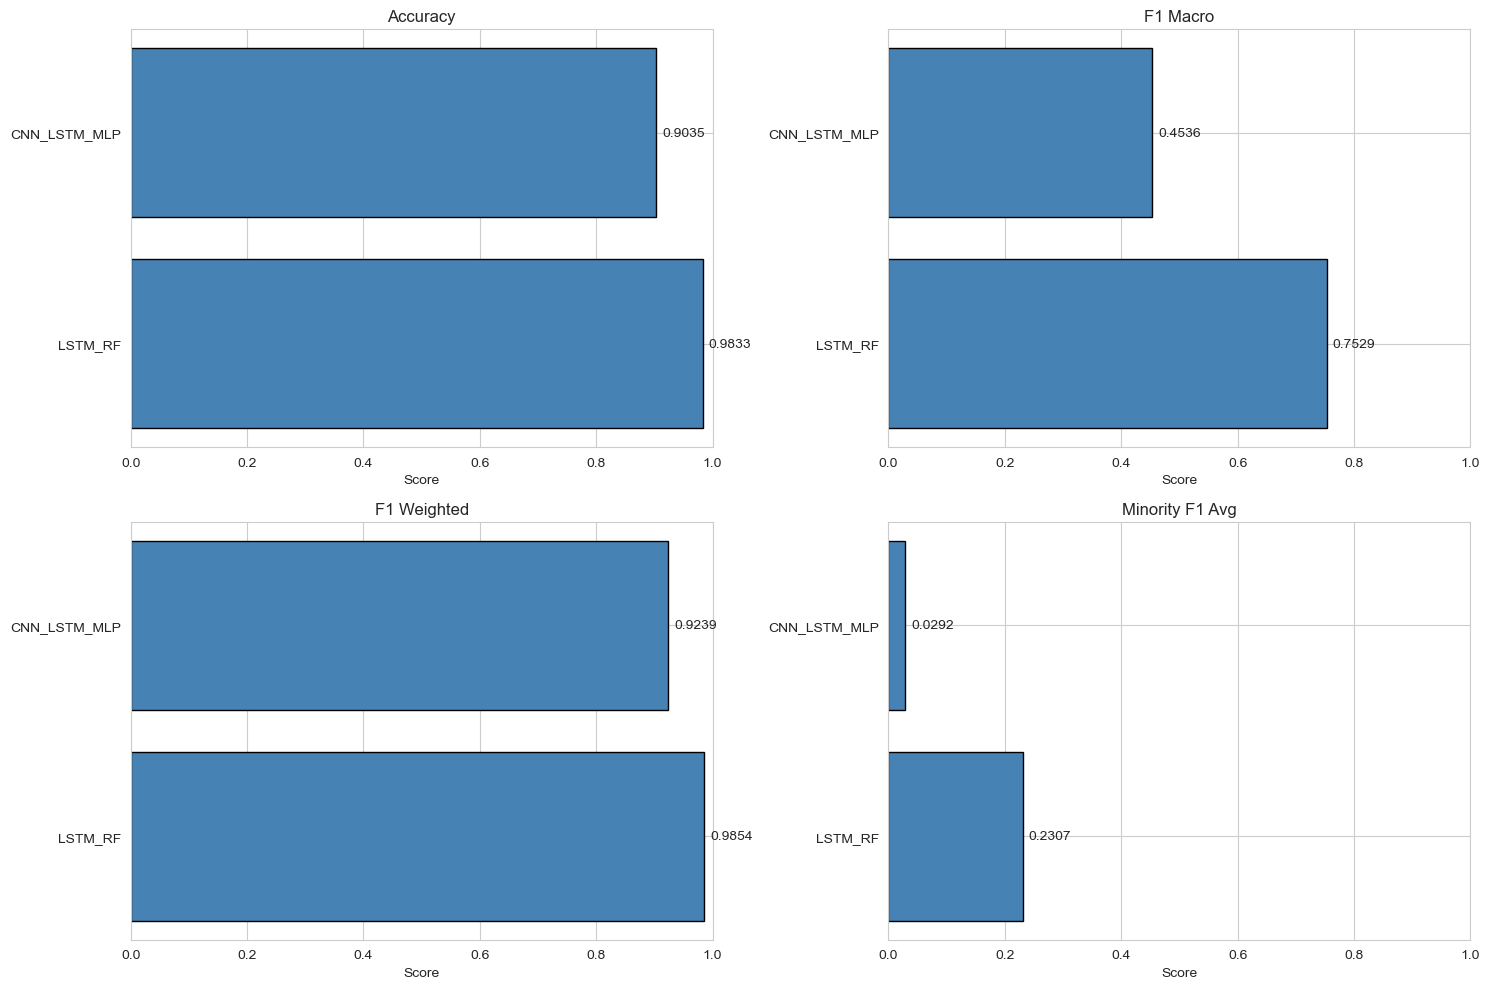

In [13]:
# Compare key metrics across models
if not model_metrics:
    print("⚠️  No model results loaded yet. Run training first (cell 9)!")
else:
    metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'minority_f1_avg']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics_to_plot):
        values = [model_metrics[m].get(metric, 0) for m in model_list if m in model_metrics]
        model_names = [m.upper() for m in model_list if m in model_metrics]
        
        if not values:
            axes[idx].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[idx].axis('off')
            continue
        
        axes[idx].barh(model_names, values, color='steelblue', edgecolor='black')
        axes[idx].set_xlabel('Score')
        axes[idx].set_title(f'{metric.replace("_", " ").title()}')
        axes[idx].set_xlim(0, 1.0)
        
        # Add value labels
        for i, v in enumerate(values):
            axes[idx].text(v + 0.01, i, f'{v:.4f}', va='center')

    plt.tight_layout()
    plt.show()

In [14]:
# Display detailed metrics for each model
if not model_metrics:
    print("⚠️  No model results loaded yet. Run training first (cell 9)!")
else:
    from scipy import stats
    
    for model_name, metrics in model_metrics.items():
        print(f"\n{'='*80}")
        print(f"Detailed Metrics: {model_name.upper()}")
        print(f"{'='*80}")
        
        # Basic metrics
        print(f"\nBasic Metrics:")
        print(f"  Accuracy:             {metrics.get('accuracy', 0):.4f}")
        print(f"  Precision (Macro):    {metrics.get('precision_macro', 0):.4f}")
        print(f"  Precision (Weighted): {metrics.get('precision_weighted', 0):.4f}")
        print(f"  Recall (Macro):       {metrics.get('recall_macro', 0):.4f}")
        print(f"  Recall (Weighted):    {metrics.get('recall_weighted', 0):.4f}")
        print(f"  F1 (Macro):           {metrics.get('f1_macro', 0):.4f}")
        print(f"  F1 (Weighted):        {metrics.get('f1_weighted', 0):.4f}")
        
        # Average F1 with 95% Confidence Interval
        per_class_metrics = metrics.get('per_class_metrics', {})
        if per_class_metrics:
            f1_scores = [v.get('f1', 0) for v in per_class_metrics.values()]
            avg_f1 = np.mean(f1_scores)
            
            if len(f1_scores) > 1:
                ci = stats.t.interval(0.95, len(f1_scores)-1, 
                                     loc=avg_f1, 
                                     scale=stats.sem(f1_scores))
                print(f"\nAverage F1 Score:")
                print(f"  Mean:               {avg_f1:.4f}")
                print(f"  95% CI:             [{ci[0]:.4f}, {ci[1]:.4f}]")
                print(f"  Std Dev:            {np.std(f1_scores):.4f}")
        
        # Additional metrics if available
        if 'minority_f1_avg' in metrics:
            print(f"\nMinority Classes (3, 4):")
            print(f"  Minority F1 (Avg):    {metrics.get('minority_f1_avg', 0):.4f}")
        if 'roc_auc' in metrics:
            print(f"  ROC-AUC:              {metrics.get('roc_auc', 0):.4f}")
        if 'cohen_kappa' in metrics:
            print(f"  Cohen's Kappa:        {metrics.get('cohen_kappa', 0):.4f}")
        
        # Per-class metrics if available
        if 'classification_report' in metrics:
            print(f"\nPer-Class Metrics:")
            report = metrics['classification_report']
            for class_id in sorted([k for k in report.keys() if k.isdigit()]):
                class_metrics = report[class_id]
                print(f"  Class {class_id}:")
                print(f"    Precision: {class_metrics.get('precision', 0):.4f}")
                print(f"    Recall:    {class_metrics.get('recall', 0):.4f}")
                print(f"    F1-Score:  {class_metrics.get('f1-score', 0):.4f}")
                print(f"    Support:   {int(class_metrics.get('support', 0))}")


Detailed Metrics: LSTM_RF

Basic Metrics:
  Accuracy:             0.9833
  Precision (Macro):    0.7062
  Precision (Weighted): 0.9893
  Recall (Macro):       0.9537
  Recall (Weighted):    0.9833
  F1 (Macro):           0.7529
  F1 (Weighted):        0.9854

Average F1 Score:
  Mean:               0.7529
  95% CI:             [0.4194, 1.0865]
  Std Dev:            0.3339

Minority Classes (3, 4):
  Minority F1 (Avg):    0.2307
  Cohen's Kappa:        0.9449

Per-Class Metrics:
  Class 0:
    Precision: 0.9998
    Recall:    0.9802
    F1-Score:  0.9899
    Support:   419440
  Class 1:
    Precision: 0.9920
    Recall:    0.9985
    F1-Score:  0.9952
    Support:   64352
  Class 2:
    Precision: 0.7644
    Recall:    0.9996
    F1-Score:  0.8663
    Support:   18139
  Class 3:
    Precision: 0.1606
    Recall:    0.9846
    F1-Score:  0.2762
    Support:   390
  Class 4:
    Precision: 0.1064
    Recall:    0.7143
    F1-Score:  0.1852
    Support:   7
  Class 5:
    Precision: 0.920

## 8. Visualization - Confusion Matrices

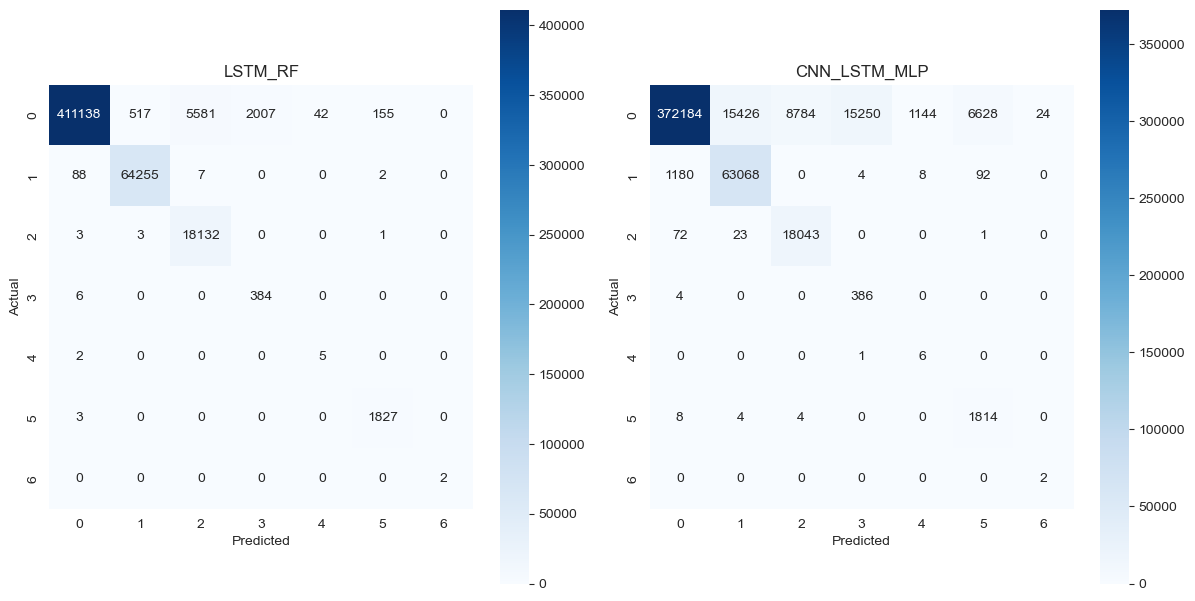

In [15]:
# Plot confusion matrices for all models
if not model_metrics:
    print("⚠️  No model results loaded yet. Run training first (cell 9)!")
else:
    from sklearn.metrics import confusion_matrix

    n_models = len(model_metrics)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, (model_name, metrics) in enumerate(model_metrics.items()):
        if 'confusion_matrix' in metrics:
            cm = metrics['confusion_matrix']
        else:
            # If confusion matrix not saved, skip
            axes[idx].text(0.5, 0.5, f'{model_name.upper()}\nConfusion Matrix\nNot Available', 
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            continue
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                    cbar=True, square=True)
        axes[idx].set_title(f'{model_name.upper()}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    # Remove extra subplots if fewer than 6 models
    for idx in range(len(model_metrics), 6):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

## 9. Best Model Selection

In [11]:
# Find best models by different criteria
if not model_metrics:
    print("⚠️  No model results loaded yet. Run training first (cell 9)!")
else:
    criteria = ['accuracy', 'f1_macro', 'f1_weighted', 'minority_f1_avg']

    print("\n" + "="*80)
    print("BEST MODELS BY CRITERION")
    print("="*80)

    for criterion in criteria:
        best_model = max(model_metrics.items(), 
                        key=lambda x: x[1].get(criterion, 0))
        best_score = best_model[1].get(criterion, 0)
        
        print(f"\n{criterion.replace('_', ' ').title()}:")
        print(f"  Best Model: {best_model[0].upper()}")
        print(f"  Score: {best_score:.4f}")

    # Overall best model (weighted combination)
    print("\n" + "-"*80)
    print("\nOverall Best Model (Weighted Average):")
    overall_scores = {}
    for model_name, metrics in model_metrics.items():
        # Weighted average: 0.3*accuracy + 0.3*f1_macro + 0.2*f1_weighted + 0.2*minority_f1_avg
        score = (0.3 * metrics.get('accuracy', 0) + 
                 0.3 * metrics.get('f1_macro', 0) + 
                 0.2 * metrics.get('f1_weighted', 0) + 
                 0.2 * metrics.get('minority_f1_avg', 0))
        overall_scores[model_name] = score

    best_overall = max(overall_scores.items(), key=lambda x: x[1])
    print(f"  Model: {best_overall[0].upper()}")
    print(f"  Weighted Score: {best_overall[1]:.4f}")

    print("="*80)


BEST MODELS BY CRITERION

Accuracy:
  Best Model: LSTM_RF
  Score: 0.9833

F1 Macro:
  Best Model: LSTM_RF
  Score: 0.7529

F1 Weighted:
  Best Model: LSTM_RF
  Score: 0.9854

Minority F1 Avg:
  Best Model: LSTM_RF
  Score: 0.2307

--------------------------------------------------------------------------------

Overall Best Model (Weighted Average):
  Model: LSTM_RF
  Weighted Score: 0.7641


## 10. Next Steps

Based on the evaluation results, you can:
1. **Fine-tune the best model** - Adjust hyperparameters for optimal performance
2. **Ensemble methods** - Combine predictions from multiple models
3. **Feature engineering** - Explore additional feature transformations
4. **Cross-validation** - Validate results with k-fold cross-validation
5. **Deploy** - Save the best model for production use

Check the saved models in `models/checkpoints/` and metrics in `results/metrics/`.